In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras
import tensorflow
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [20]:
#Nacte csv s informacemi o trenovacich obrazcich
gtsrb_base = '/kaggle/input/gtsrb-german-traffic-sign'
trainCSV = pd.read_csv(gtsrb_base + '/Train.csv')
trainCSV.head(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
5,31,27,6,5,26,22,20,Train/20/00020_00000_00005.png
6,31,28,6,6,26,23,20,Train/20/00020_00000_00006.png
7,31,28,6,6,26,23,20,Train/20/00020_00000_00007.png
8,31,29,5,6,26,24,20,Train/20/00020_00000_00008.png
9,34,32,6,6,29,26,20,Train/20/00020_00000_00009.png


In [21]:
images_dict_list = []
for i in range(trainCSV.shape[0]):
    kvp = {}
    kvp[0] = trainCSV.iloc[i]['ClassId']
    kvp[1] = gtsrb_base + '/' + trainCSV.iloc[i]['Path']
    images_dict_list.append(kvp)

In [22]:
#Nacteni jednotlivych obrazku a prislusnych popisku
data=[]
labels=[]
for kvp in images_dict_list:
    try:
        traffic_sign_data = np.array(image.load_img(kvp[1],target_size = (32,32)))
        data.append(traffic_sign_data)
        labels.append(int(kvp[0]))
    except:
        pass
print(len(data),len(labels))

39209 39209


In [23]:
#popisky obrazku
category_labels = {
    0:"Speed limit (20km/h)",
    1:"Speed limit (30km/h)",
    2:"Speed limit (50km/h)",
    3:"Speed limit (60km/h)",
    4:"Speed limit (70km/h)",
    5:"Speed limit (80km/h)",
    6:"End of speed limit (80km/h)",
    7:"Speed limit (100km/h)",
    8:"Speed limit (120km/h)",
    9:"No passing",
    10:"No passing for vehicles over 3.5 metric tons",
    11:"Right-of-way at the next intersection",
    12:"Priority road",
    13:"Yield",
    14:"Stop",
    15:"No vehicles",
    16:"Vehicles over 3.5 metric tons prohibited",
    17:"No entry",
    18:"General caution",
    19:"Dangerous curve to the left",
    20:"Dangerous curve to the right",
    21:"Double curve",
    22:"Bumpy road",
    23:"Slippery road",
    24:"Road narrows on the right",
    25:"Road work",
    26:"Traffic signals",
    27:"Pedestrians",
    28:"Children crossing",
    29:"Bicycles crossing",
    30:"Beware of ice/snow",
    31:"Wild animals crossing",
    32:"End of all speed and passing limits",
    33:"Turn right ahead",
    34:"Turn left ahead",
    35:"Ahead only",
    36:"Go straight or right",
    37:"Go straight or left",
    38:"Keep right",
    39:"Keep left",
    40:"Roudabout mandatory",
    41:"End of no passing",
    42:"End of no passing by vehicles over 3.5 metric tons",
}

2949


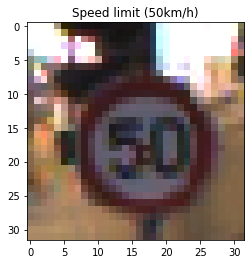

22016


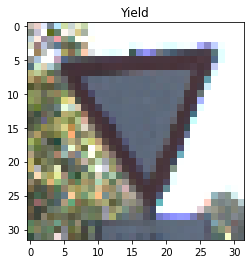

32168


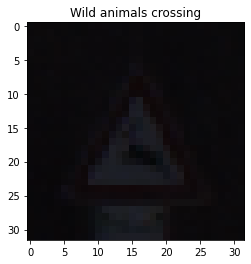

In [24]:
for i in range(3):
    rnd = random.randint(0,len(data))
    print(str(rnd))
    preview = plt.imshow(data[rnd])
    preview_title = plt.title(category_labels[labels[rnd]])
    plt.show()

In [25]:
#rozrazeni datasetu na trenovaci a testovaci data

y_categorical = tensorflow.keras.utils.to_categorical(labels,43)
print(y_categorical.shape)
X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2, random_state=123)

print('X_train length:', len(X_train))
print('y_train length:', len(y_train))
print('X_test length:', len(X_test))
print('y_test length:', len(y_test))

(39209, 43)
X_train length: 31367
y_train length: 31367
X_test length: 7842
y_test length: 7842


In [26]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
#převede z RGB 0-255 na float 0-1
X_train_norm = X_train_array/255.0

print("X_train_norm shape: ", X_train_norm.shape)
print("y_train_array shape: ", y_train_array.shape)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)
X_test_norm = X_test_array/255.0
print('X_test_norm shape: ', X_test_norm.shape)
print("y_test_array shape: ", y_test_array.shape)

X_train_norm shape:  (31367, 32, 32, 3)
y_train_array shape:  (31367, 43)
X_test_norm shape:  (7842, 32, 32, 3)
y_test_array shape:  (7842, 43)


In [27]:
#nacteni/stazeni modelu
resnet_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (32,32,3))

94781440/94765736 [==============================] - 3s 0us/step


In [28]:
#uprava modelu pro trenovani
resnet_output = resnet_model.output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)
predictions = Dense(43, activation = 'softmax')(resnet_output)
model = Model(inputs = resnet_model.input, outputs = predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
#trenovani modelu - 20 epoch, davkovani po 256
fit_history = model.fit(X_train_norm,y_train_array,
                        validation_data=(X_test_norm,y_test_array),
                        batch_size=256,
                        epochs=20, verbose=1)

2023-01-03 17:05:52.620767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
123/123 [==============================] - 342s 3s/step - loss: 1.0992 - accuracy: 0.7115 - val_loss: 6.0563 - val_accuracy: 0.0454
Epoch 2/20
123/123 [==============================] - 326s 3s/step - loss: 0.1238 - accuracy: 0.9636 - val_loss: 4.1144 - val_accuracy: 0.0479
Epoch 3/20
123/123 [==============================] - 330s 3s/step - loss: 0.0759 - accuracy: 0.9780 - val_loss: 3.7502 - val_accuracy: 0.0735
Epoch 4/20
123/123 [==============================] - 328s 3s/step - loss: 0.0400 - accuracy: 0.9888 - val_loss: 3.1511 - val_accuracy: 0.2969
Epoch 5/20
123/123 [==============================] - 324s 3s/step - loss: 0.0582 - accuracy: 0.9852 - val_loss: 3.1120 - val_accuracy: 0.3528
Epoch 6/20
123/123 [==============================] - 325s 3s/step - loss: 0.0386 - accuracy: 0.9890 - val_loss: 1.2520 - val_accuracy: 0.6775
Epoch 7/20
123/123 [==============================] - 329s 3s/step - loss: 0.0334 - accuracy: 0.9911 - val_loss: 0.9069 - val_accuracy: 0.7934

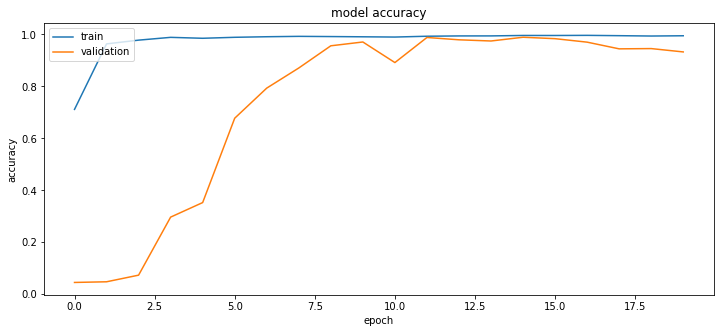

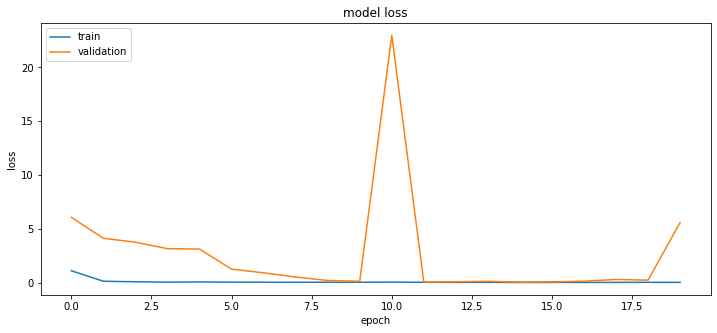

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure(figsize=(12, 5))

plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
loss, acc = model.evaluate(X_test_norm, y_test_array)
print('Accuracy: ', acc, '\nLoss    : ', loss)

246/246 [==============================] - 29s 119ms/step - loss: 5.5781 - accuracy: 0.9327
Accuracy:  0.9326702356338501 
Loss    :  5.578070163726807


In [32]:
#predikce modelu
model_predictions = model.predict(X_test_norm)
predictions = np.argmax(model_predictions, axis = 1)
actual_values = np.argmax(y_test_array, axis = 1)


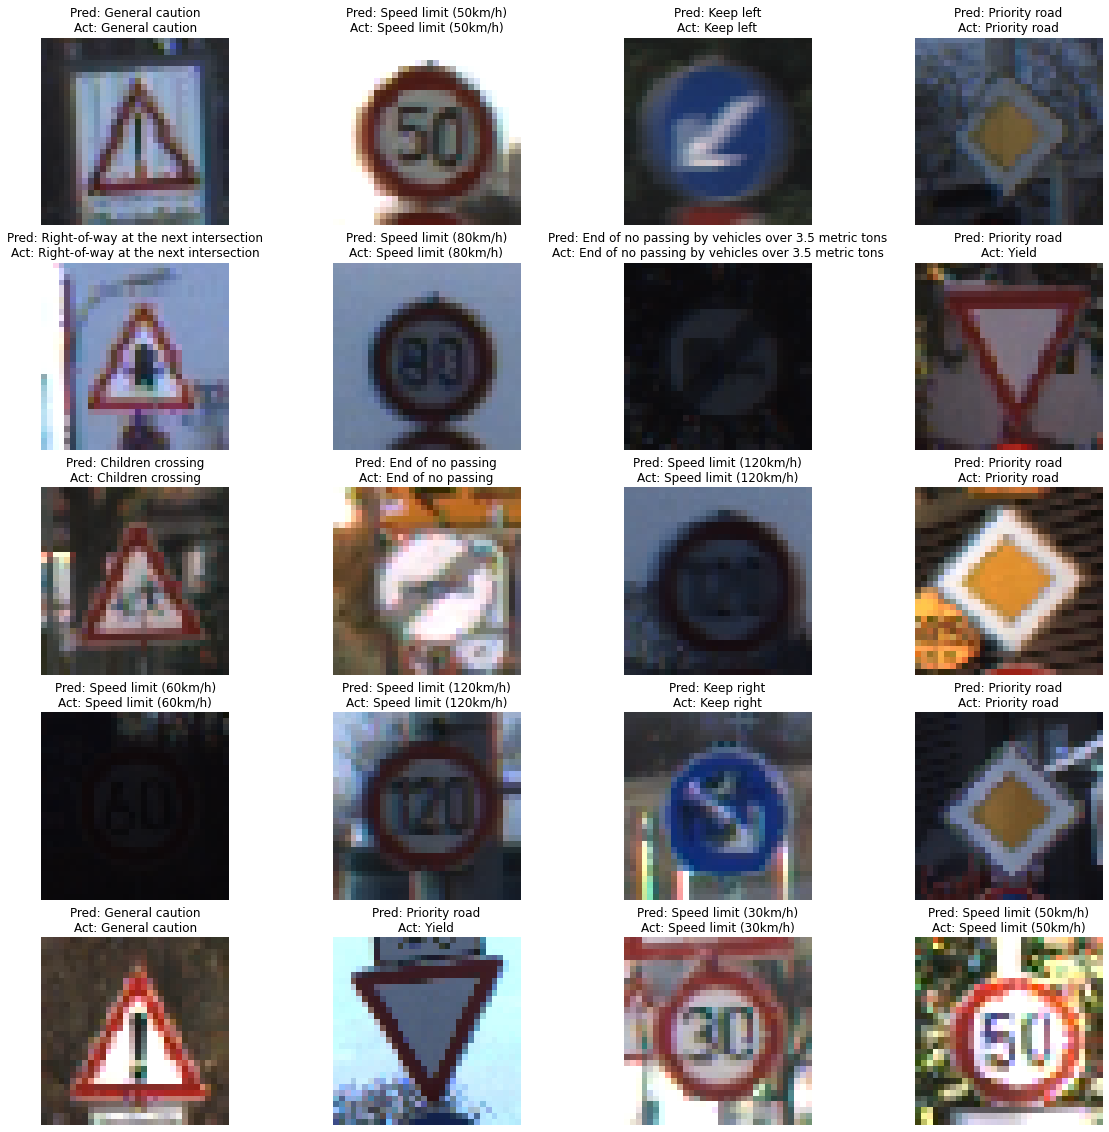

In [33]:
def show_prediction_results(x_test,predict,act,i):
    image = plt.imshow(x_test[i])
    l=plt.title('Pred: ' + category_labels[predict[i]] + '\nAct: ' + category_labels[act[i]])
    ax.grid(False)
    ax.axis('off')    
    return image, l
fig = plt.figure(figsize=(20, 20))


for i in range(20):
    rnd = random.randint(0,len(X_test))
    ax = fig.add_subplot(5, 4, i + 1)
    show_prediction_results(X_test,predictions,actual_values, rnd)

plt.show()


In [34]:
model.save('/kaggle/working/smap_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [35]:
loaded = keras.models.load_model('/kaggle/working/smap_model.h5')

In [36]:
def predict_sign(pathToImage):
    listOfImgData = []
    testImg = np.array(image.load_img(pathToImage, target_size=(32,32)))
    listOfImgData.append(testImg)
    imgArray = np.array(listOfImgData)
    normalizedImg = imgArray / 255.0
    imgPredictions = loaded.predict(normalizedImg)
    pr = np.argmax(imgPredictions, axis = 1)
    plt.imshow(testImg)
    plt.title(category_labels[pr[0]])
    plt.show()

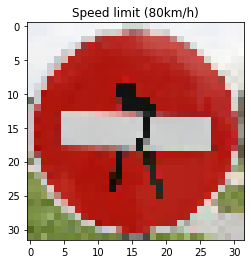

In [38]:
test_prediction = predict_sign('/kaggle/input/customsigns/Screenshot_8.png')